# VQE-based Integer Factorization (N = 35)
This notebook implements a Qiskit version of a hybrid quantum-classical VQE-based algorithm to factorize composite numbers N. <br /><br />
Optimizers (qiskit_algorithms.optimizers): <br />
https://qiskit-community.github.io/qiskit-algorithms/apidocs/qiskit_algorithms.optimizers.html

In [9]:
import sys, time
print(sys.executable)  # 顯示目前 Python 執行環境

/opt/anaconda3/envs/vqe-env2/bin/python


In [10]:
from qiskit import QuantumCircuit, transpile  # 建立與編譯量子電路
from qiskit_aer import Aer  # Qiskit 模擬器後端
from qiskit.circuit import ParameterVector  # 用於建立變數參數
import numpy as np
# from scipy.optimize import minimize  # 經典最佳化器
from qiskit_algorithms.optimizers import (COBYLA, SPSA, BOBYQA, GSLS, GradientDescent, NELDER_MEAD, NFT, L_BFGS_B, POWELL, ADAM, CG, UMDA)  # Qiskit內部優化器
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

In [11]:
# ------------------------------
# 1. Configuration
# ------------------------------
TARGET_N = 35
# SHOTS = 1024
# CVaR_ALPHA = 0.2

## Step 1: Define the variational ansatz

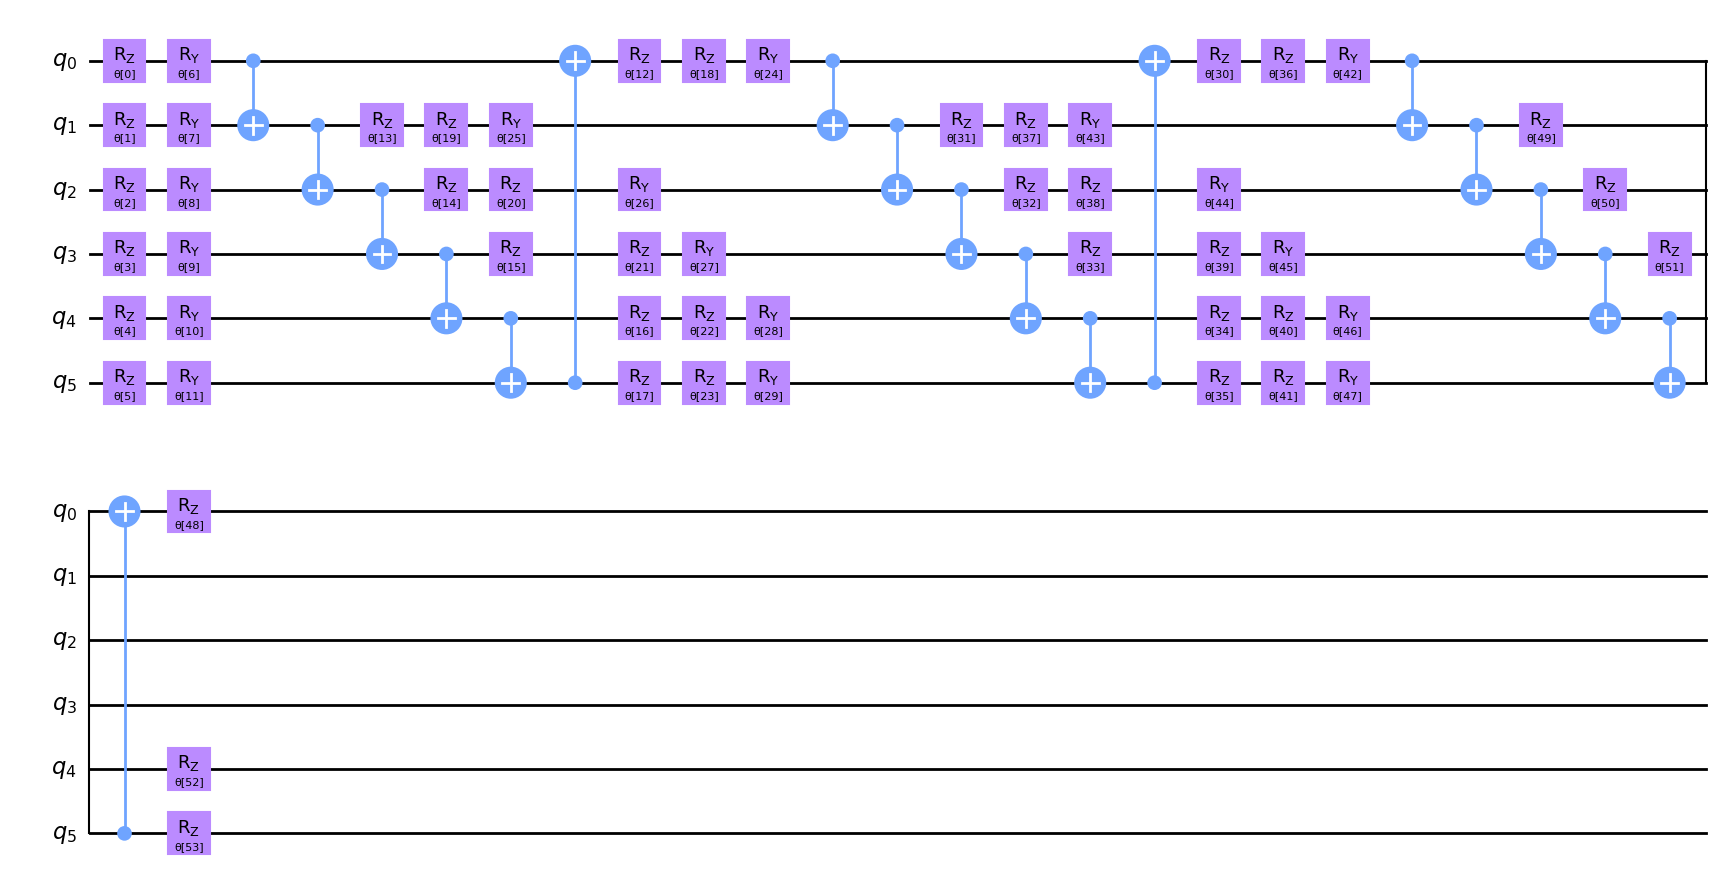

In [12]:
# ------------------------------
# 2. Ansatz Construction
# ------------------------------
def build_ansatz(n_qubits, depth=3):  # 建立變分電路ansatz, 包含多層Rz, CX
    params = ParameterVector("θ", length=n_qubits * 3 * depth)  # params 是 Symbolic 參數向量：θ₀, θ₁, …, θₙ₋₁
    qc = QuantumCircuit(n_qubits)

    for d in range(depth):
        for i in range(n_qubits):  # 為每個 qubit 加上 Rz, Ry
            qc.rz(params[d * n_qubits * 3 + i], i)
            qc.ry(params[d * n_qubits * 3 + n_qubits + i], i)
            
        for i in range(n_qubits):  # 使用環狀 entanglement 結構：i -> (i+1)%n
            qc.cx(i, (i + 1) % n_qubits)
            
        for i in range(n_qubits):  # 加上額外一層 Rz 作為可選強化
            qc.rz(params[d * n_qubits * 3 + 2 * n_qubits + i], i)

    return qc, params

ansatz, params = build_ansatz(6)  # 建立 ansatz 並畫出其電路圖
ansatz.draw("mpl")

## Step 2: Cost function to evaluate (x * y - N)^2

In [13]:
# ------------------------------
# 3. Utilities
# ------------------------------
def binary_to_xy(bitstring):  # 將 bitstring 轉換成 (x, y)
    b = [int(x) for x in bitstring]
    x = 2 + b[0] + 2 * b[1] + 4 * b[2]
    y = 2 + b[3] + 2 * b[4] + 4 * b[5]
    return x, y

def cost_function(counts, alpha=0.2):  # 計算 CVaR 損失，並記錄正確答案 (x, y) 的統計
    shots = sum(counts.values())
    cost_list = []
    correct_factors = []

    for bitstring, count in counts.items():
        x, y = binary_to_xy(bitstring[::-1])
        cost = ((x * y - TARGET_N) ** 2)
        cost_list.extend([cost] * count)
        if x * y == TARGET_N:
            correct_factors.extend([(x, y)] * count)

    cost_list.sort()
    cutoff = int(alpha * shots)
    cvar_cost = np.mean(cost_list[:cutoff]) if cutoff > 0 else np.mean(cost_list)

    if correct_factors:
        counter = Counter(correct_factors)
        (x, y), cnt = counter.most_common(1)[0]
        confidence = cnt / shots  # 輸出最高信心水準的因數
    return cvar_cost

## Step 3: Expectation wrapper using measurement results

In [14]:
# ------------------------------
# 4. Expectation Function
# ------------------------------
backend = Aer.get_backend("aer_simulator")  # 初始化後端模擬器
final_xy_counter = defaultdict(int)  # 用來累積所有量測結果的 (x, y) 對應次數

def expectation(theta_vals):  # 經典最佳化器呼叫的期望值函數, 會執行電路並計算 CVaR 成本
    global final_xy_counter
    final_xy_counter.clear()

    bound = ansatz.assign_parameters({params[i]: theta_vals[i] for i in range(len(params))}).copy() # 每次優化器執行一輪後, 就會產生一組新的theta_vals, 將參數綁定進 ansatz
    bound.measure_all()  # 加入全量測
    compiled = transpile(bound, backend)  # 編譯後送入模擬器
    job = backend.run(compiled, shots=1024)
    counts = job.result().get_counts()

    for b, c in counts.items():  # 累加每組 (x, y) 出現次數
        x, y = binary_to_xy(b[::-1])
        final_xy_counter[(x, y)] += c

    return cost_function(counts)

## Step 4: Run classical optimizer


Optimizer: COBYLA
Iterations: None
Function evaluations: 200
Elapsed time: 0.83 seconds
Best cost: 0.0

Best parameterized circuit:


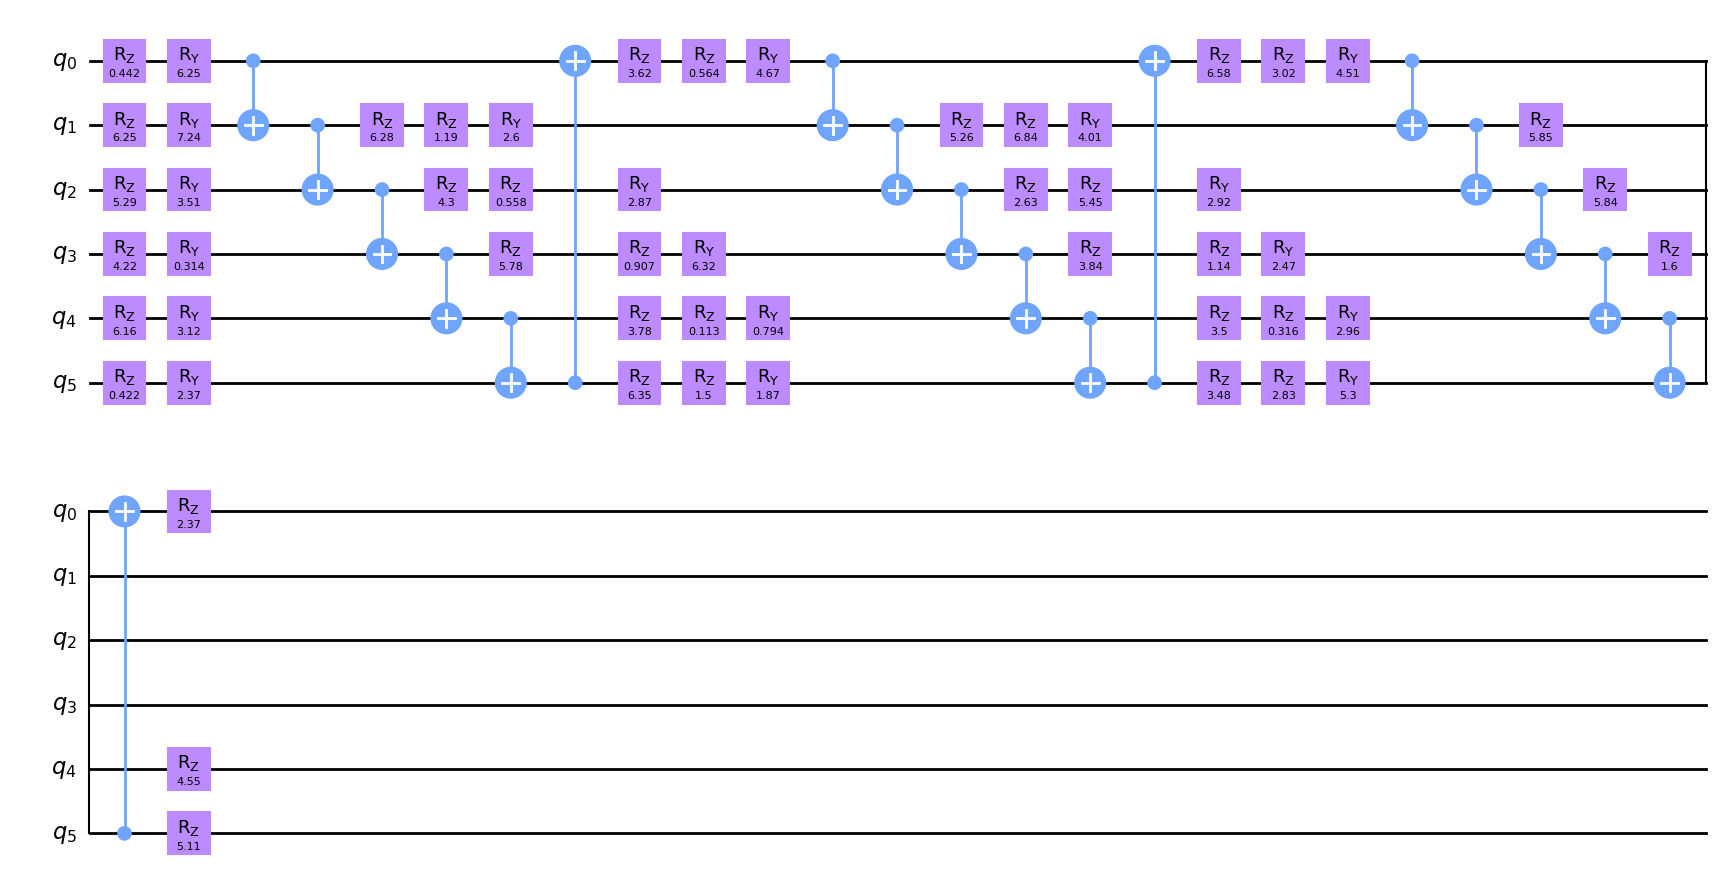


Optimizer: SPSA
Iterations: 500
Function evaluations: 1000
Elapsed time: 4.32 seconds
Best cost: 0.8823529411764706

Best parameterized circuit:


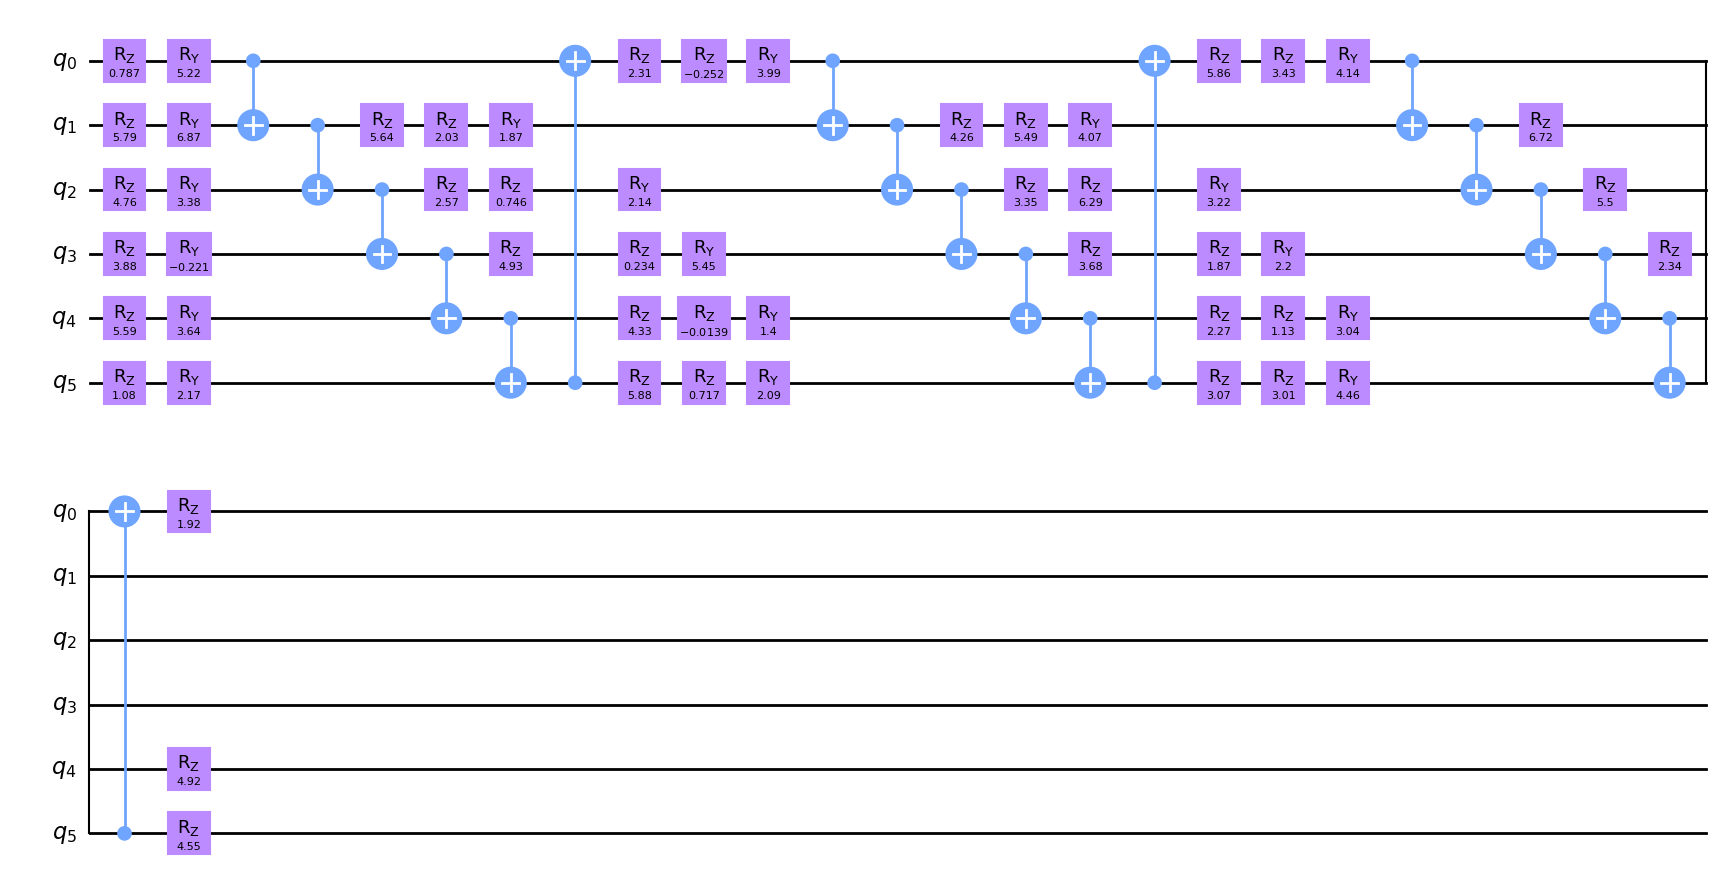

/opt/anaconda3/envs/vqe-env2/lib/python3.9/site-packages/pybobyqa/solver.py:780: RuntimeWarning: maxfun <= npt: Are you sure your budget is large enough?
  warnings.warn("maxfun <= npt: Are you sure your budget is large enough?", RuntimeWarning)



Optimizer: BOBYQA
Iterations: None
Function evaluations: 500
Elapsed time: 2.04 seconds
Best cost: 1.3333333333333333

Best parameterized circuit:


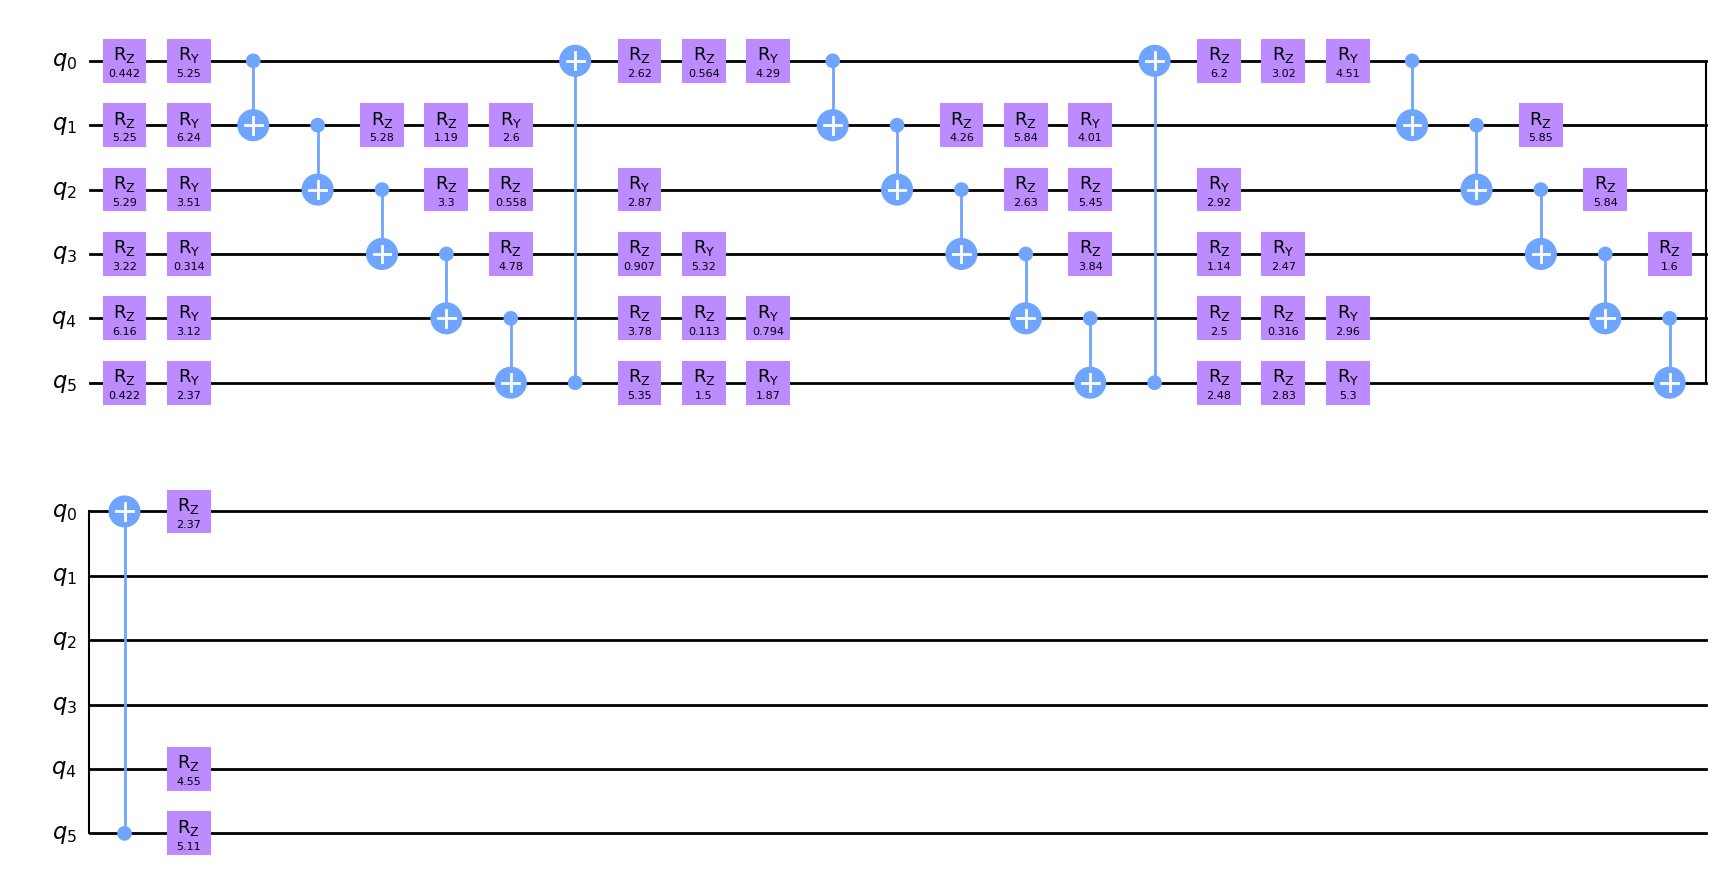


Optimizer: GSLS
Iterations: None
Function evaluations: 1541
Elapsed time: 6.26 seconds
Best cost: 0.4264705882352941

Best parameterized circuit:


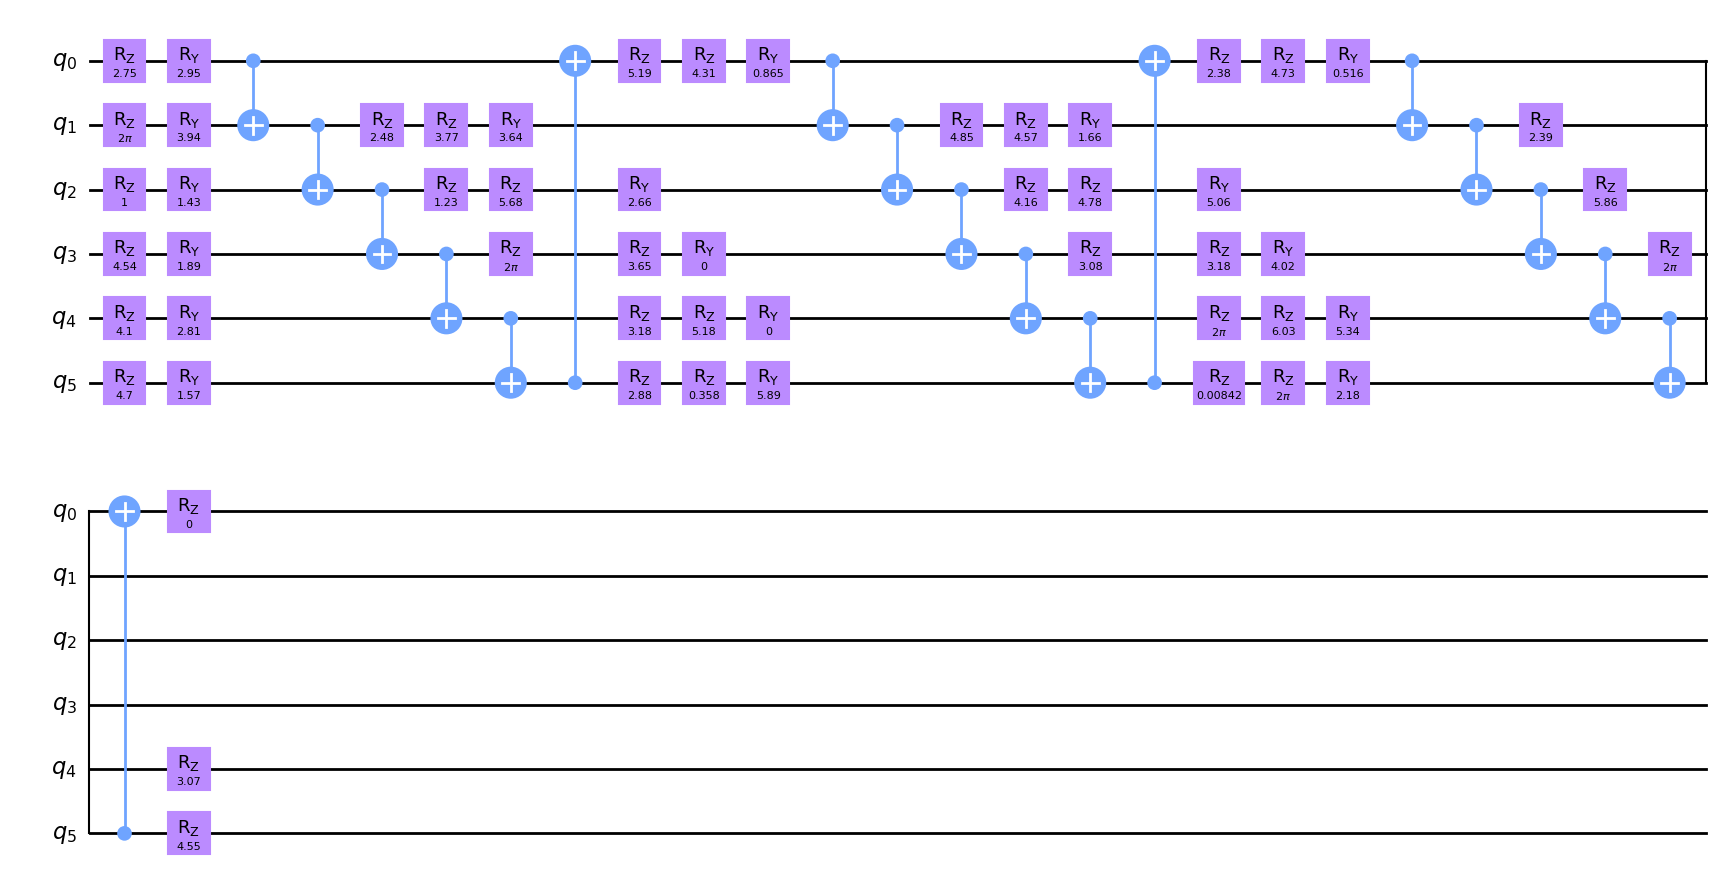


Optimizer: GradientDescent
Iterations: 500
Function evaluations: 27500
Elapsed time: 112.88 seconds
Best cost: 7.367647058823529

Best parameterized circuit:


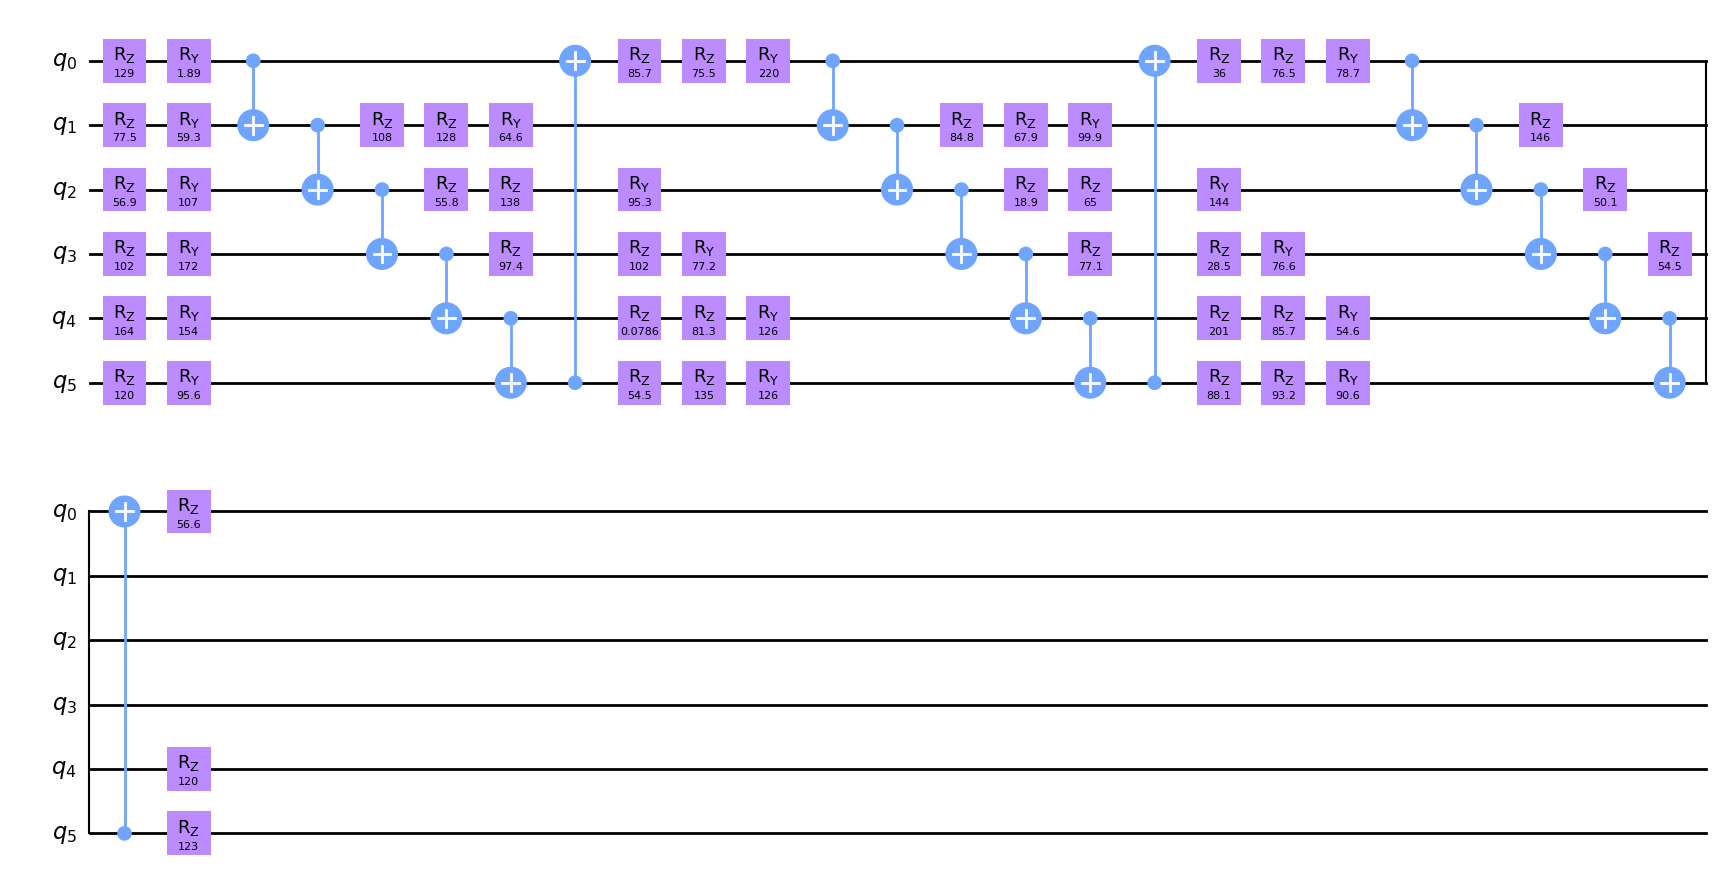


Optimizer: NELDER_MEAD
Iterations: 200
Function evaluations: 898
Elapsed time: 3.70 seconds
Best cost: 15.27450980392157

Best parameterized circuit:


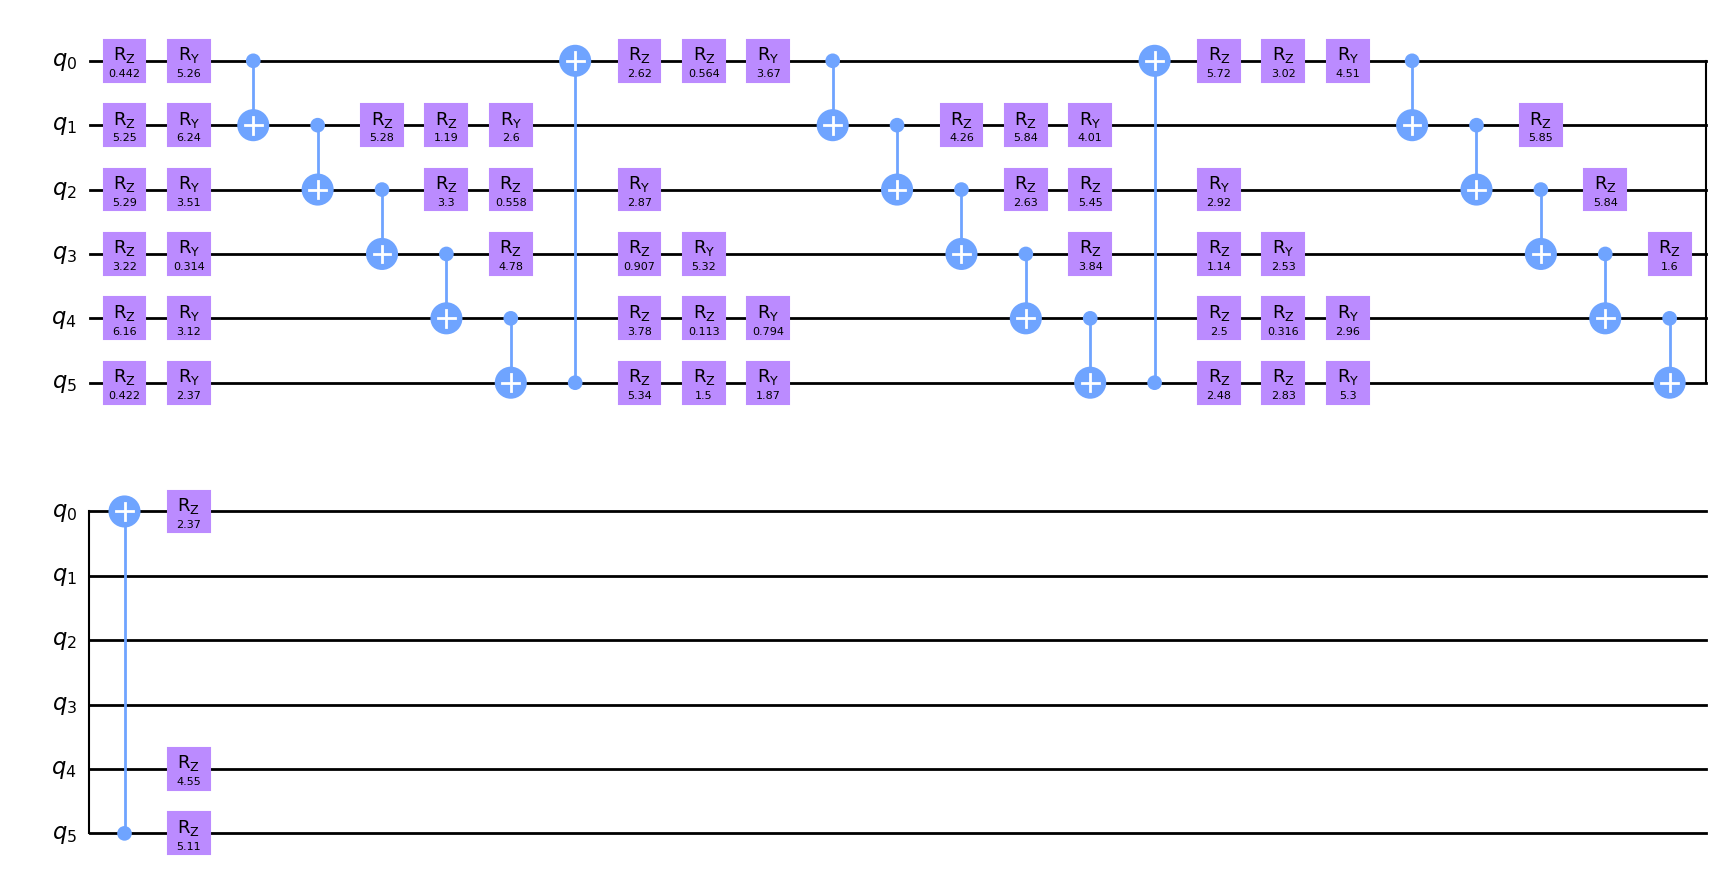


Optimizer: NFT
Iterations: 200
Function evaluations: 407
Elapsed time: 1.66 seconds
Best cost: 0.8774509803921569

Best parameterized circuit:


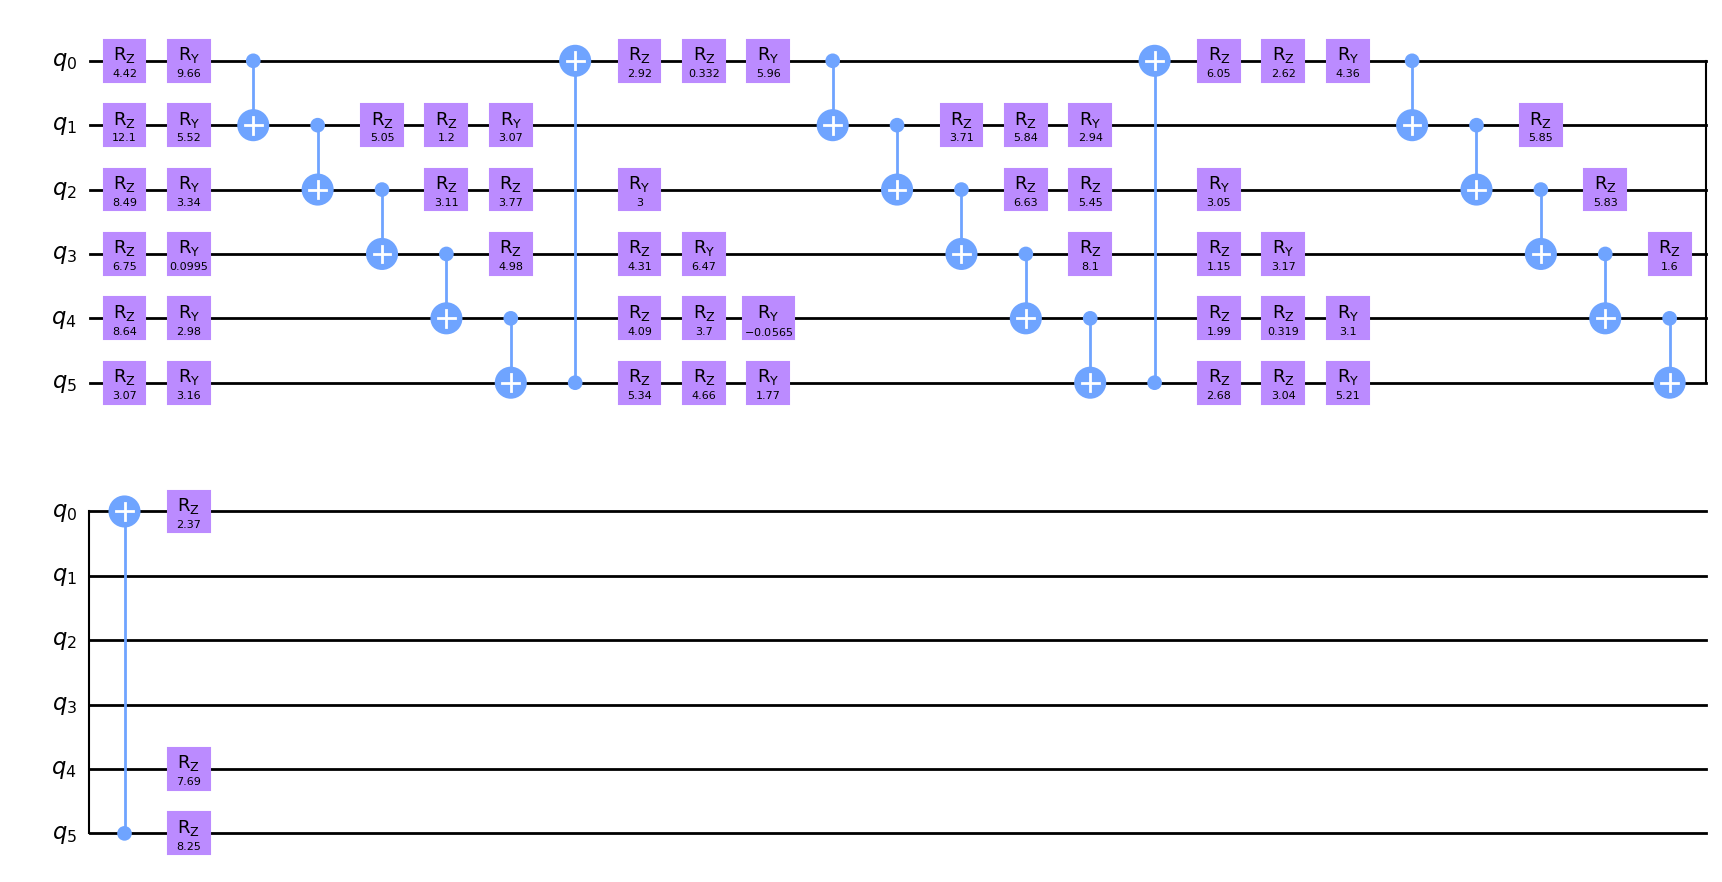


Optimizer: L_BFGS_B
Iterations: 3
Function evaluations: 1595
Elapsed time: 6.52 seconds
Best cost: 36.60294117647059

Best parameterized circuit:


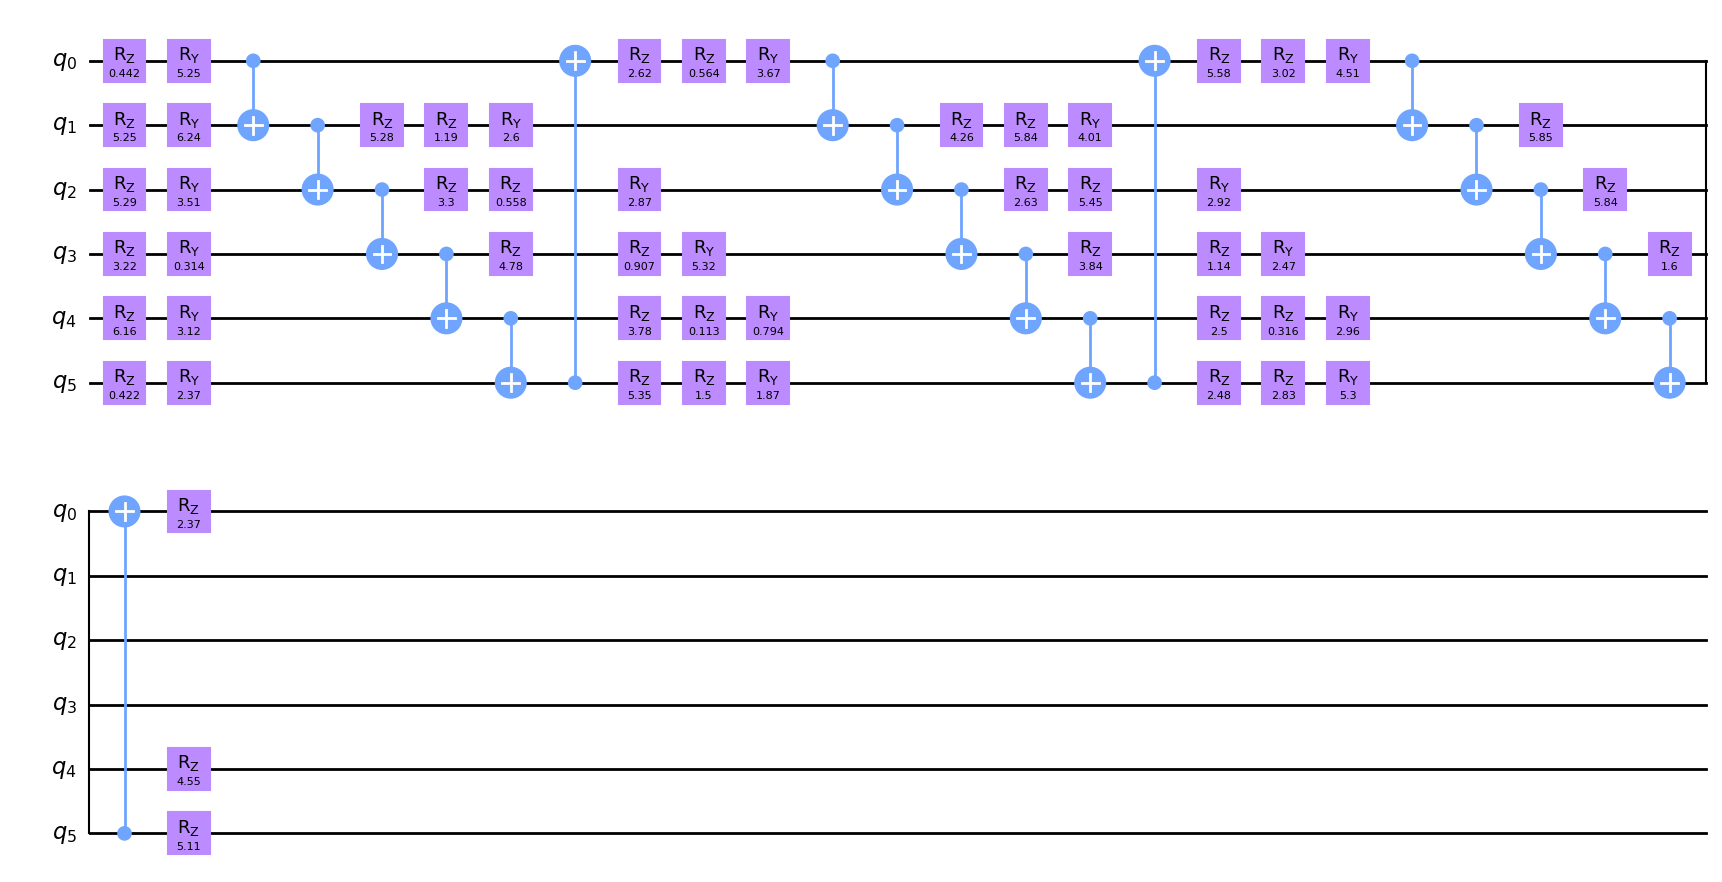


Optimizer: POWELL
Iterations: 0
Function evaluations: 1000
Elapsed time: 4.34 seconds
Best cost: 0.0

Best parameterized circuit:


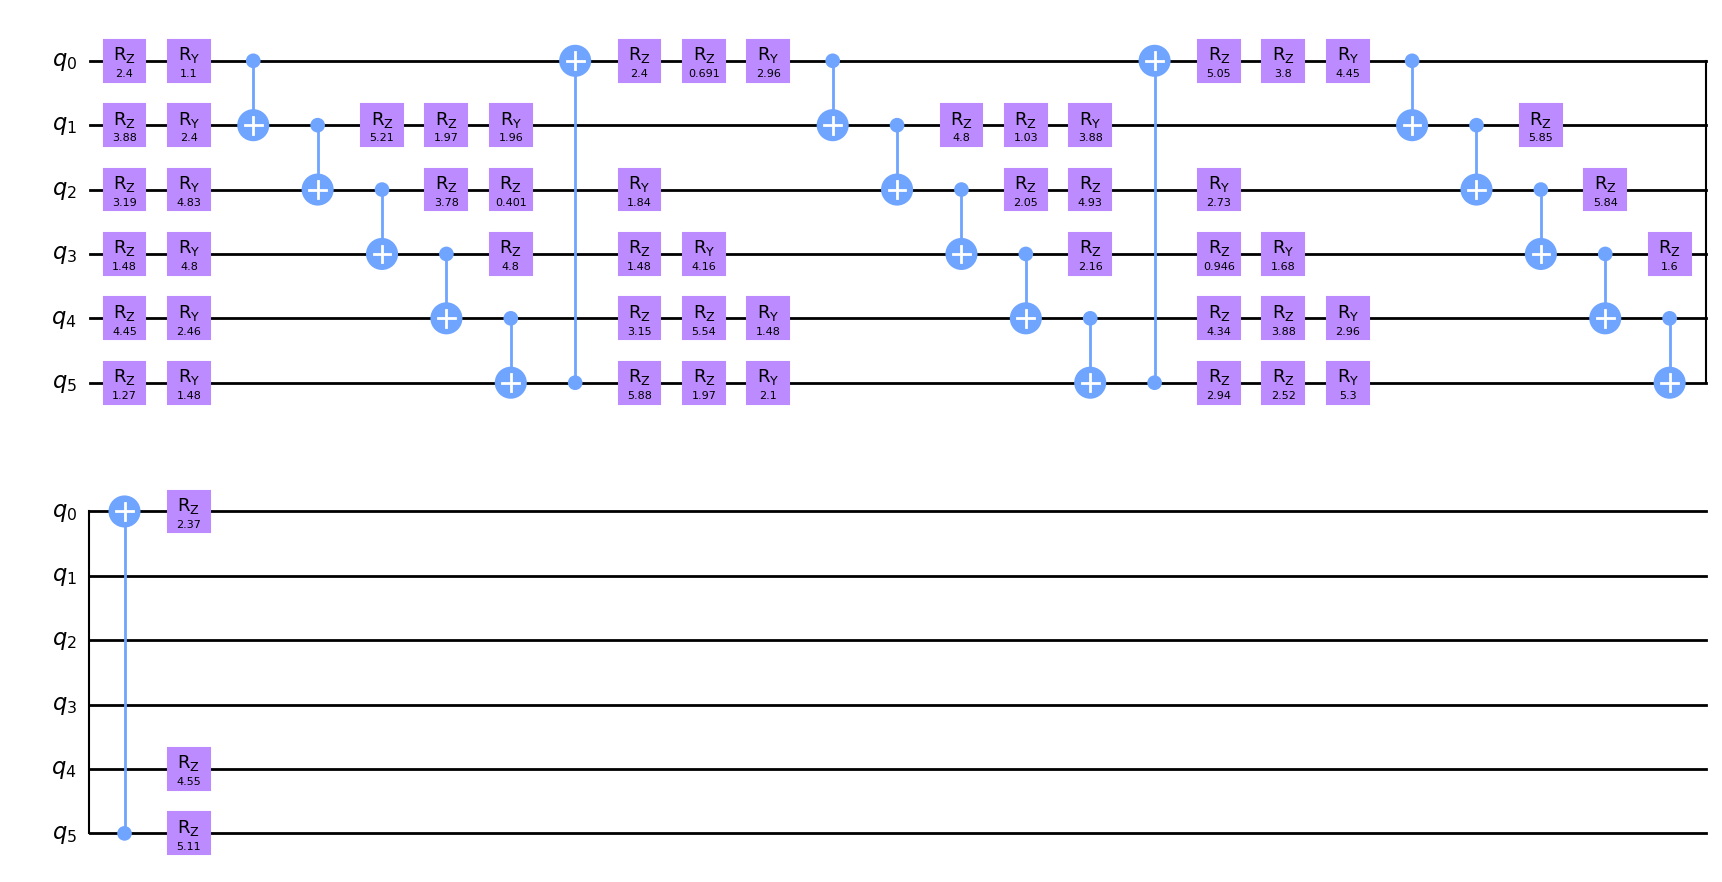


Optimizer: ADAM
Iterations: None
Function evaluations: 500
Elapsed time: 116.40 seconds
Best cost: 24.725490196078432

Best parameterized circuit:


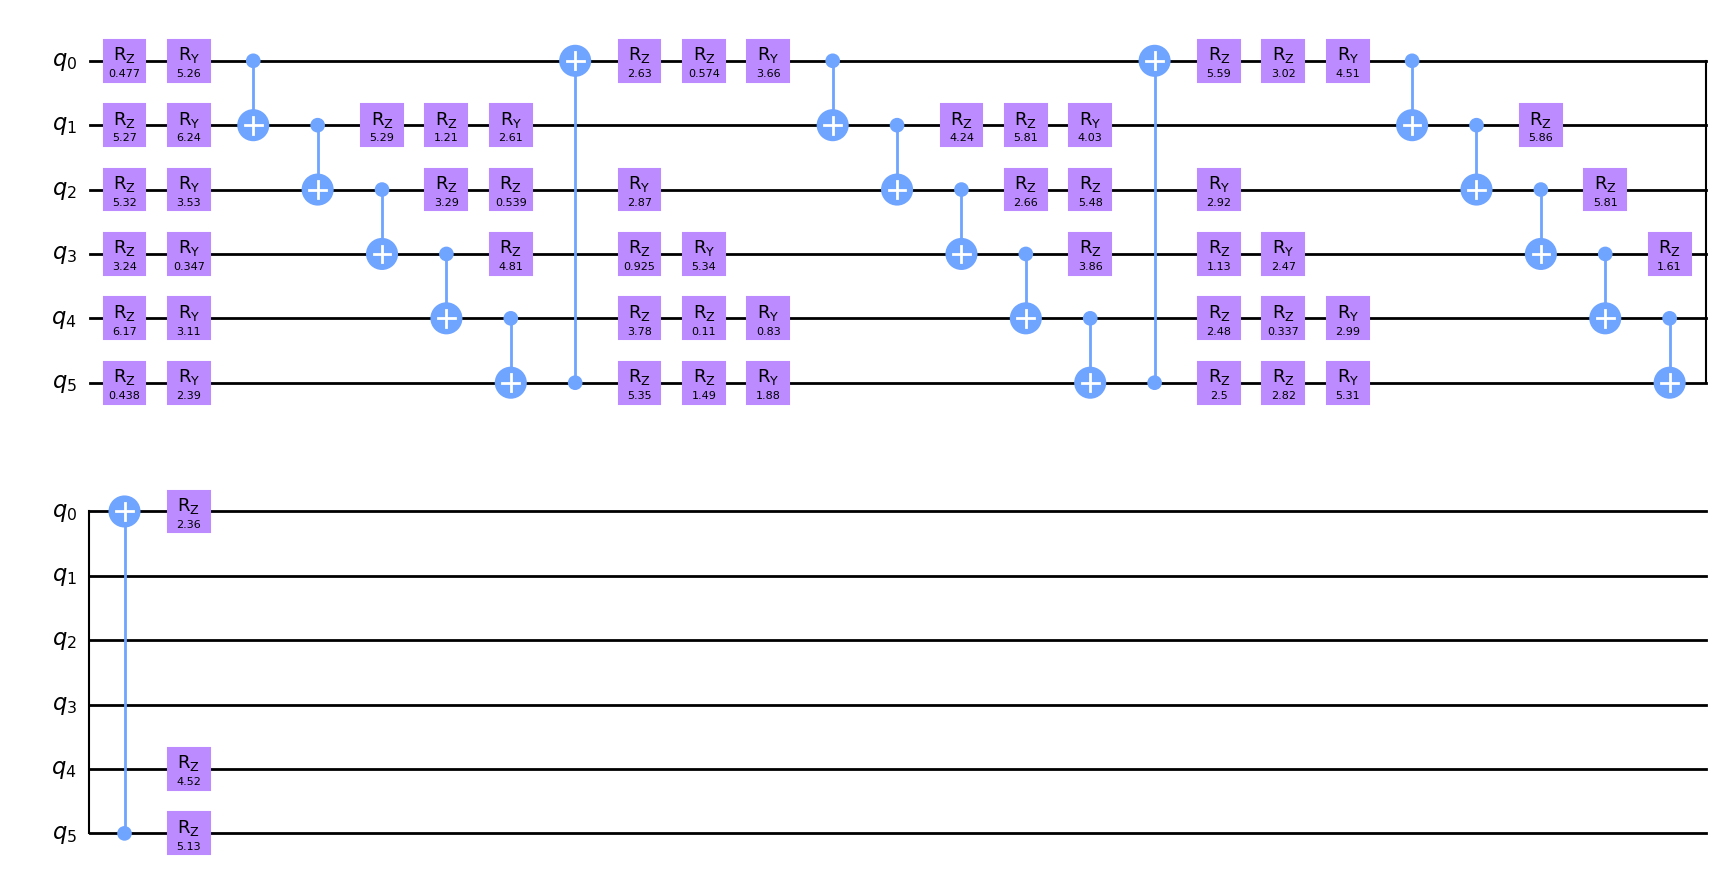


Optimizer: CG
Iterations: 1
Function evaluations: 1551
Elapsed time: 6.72 seconds
Best cost: 25.715686274509803

Best parameterized circuit:


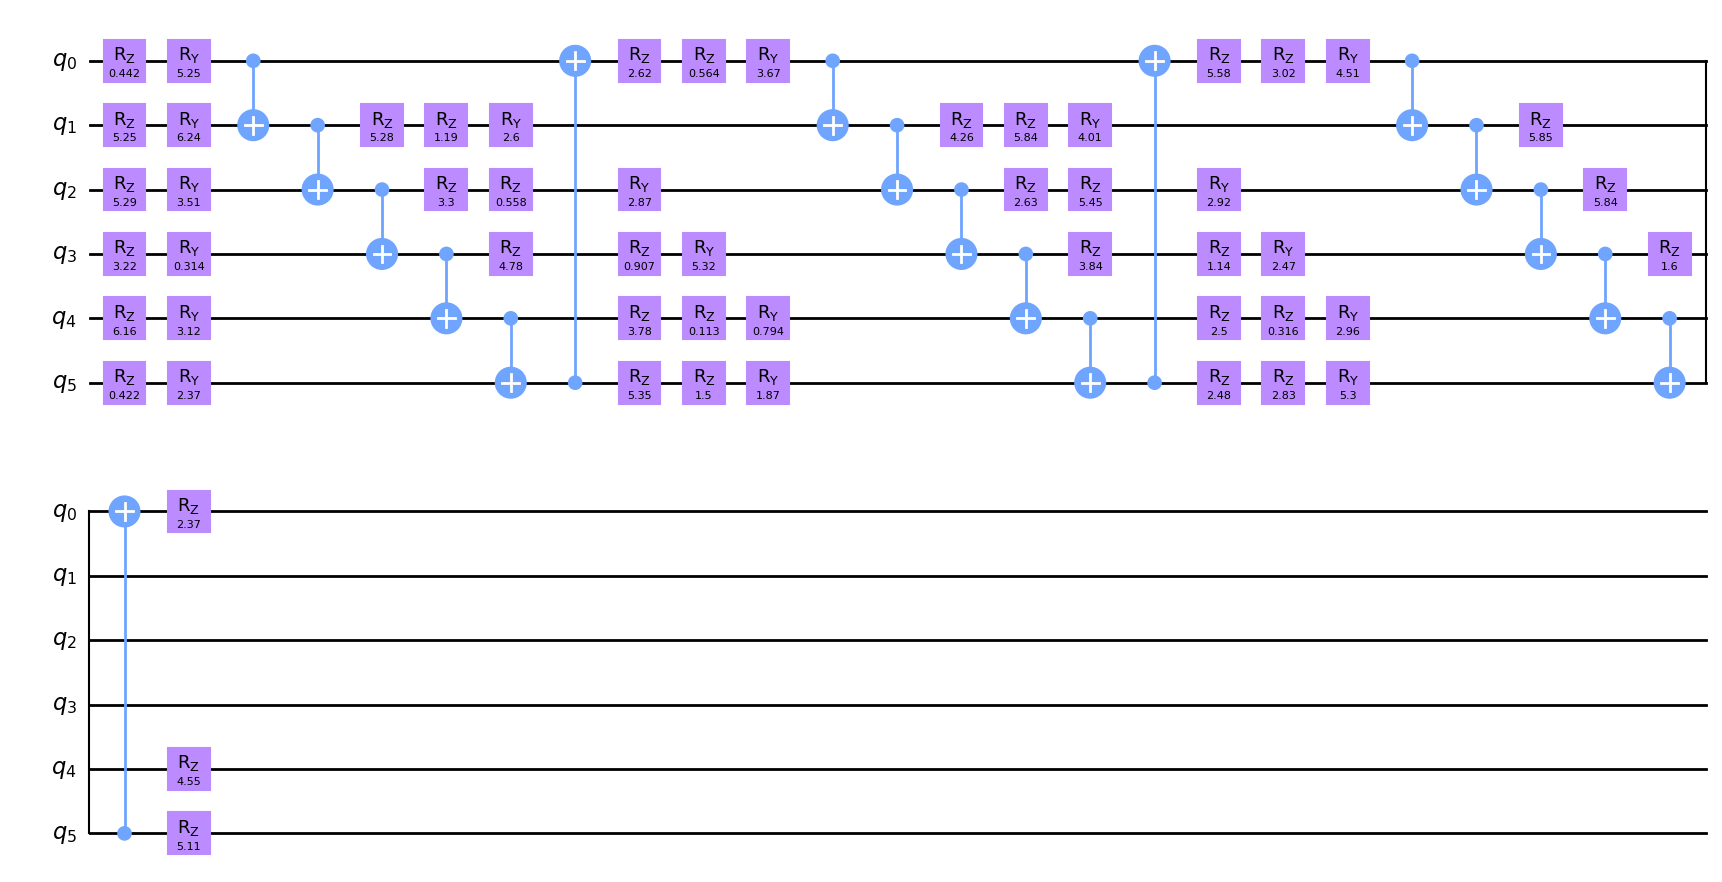


Optimizer: UMDA
Iterations: None
Function evaluations: 2040
Elapsed time: 10.25 seconds
Best cost: 0.0

Best parameterized circuit:


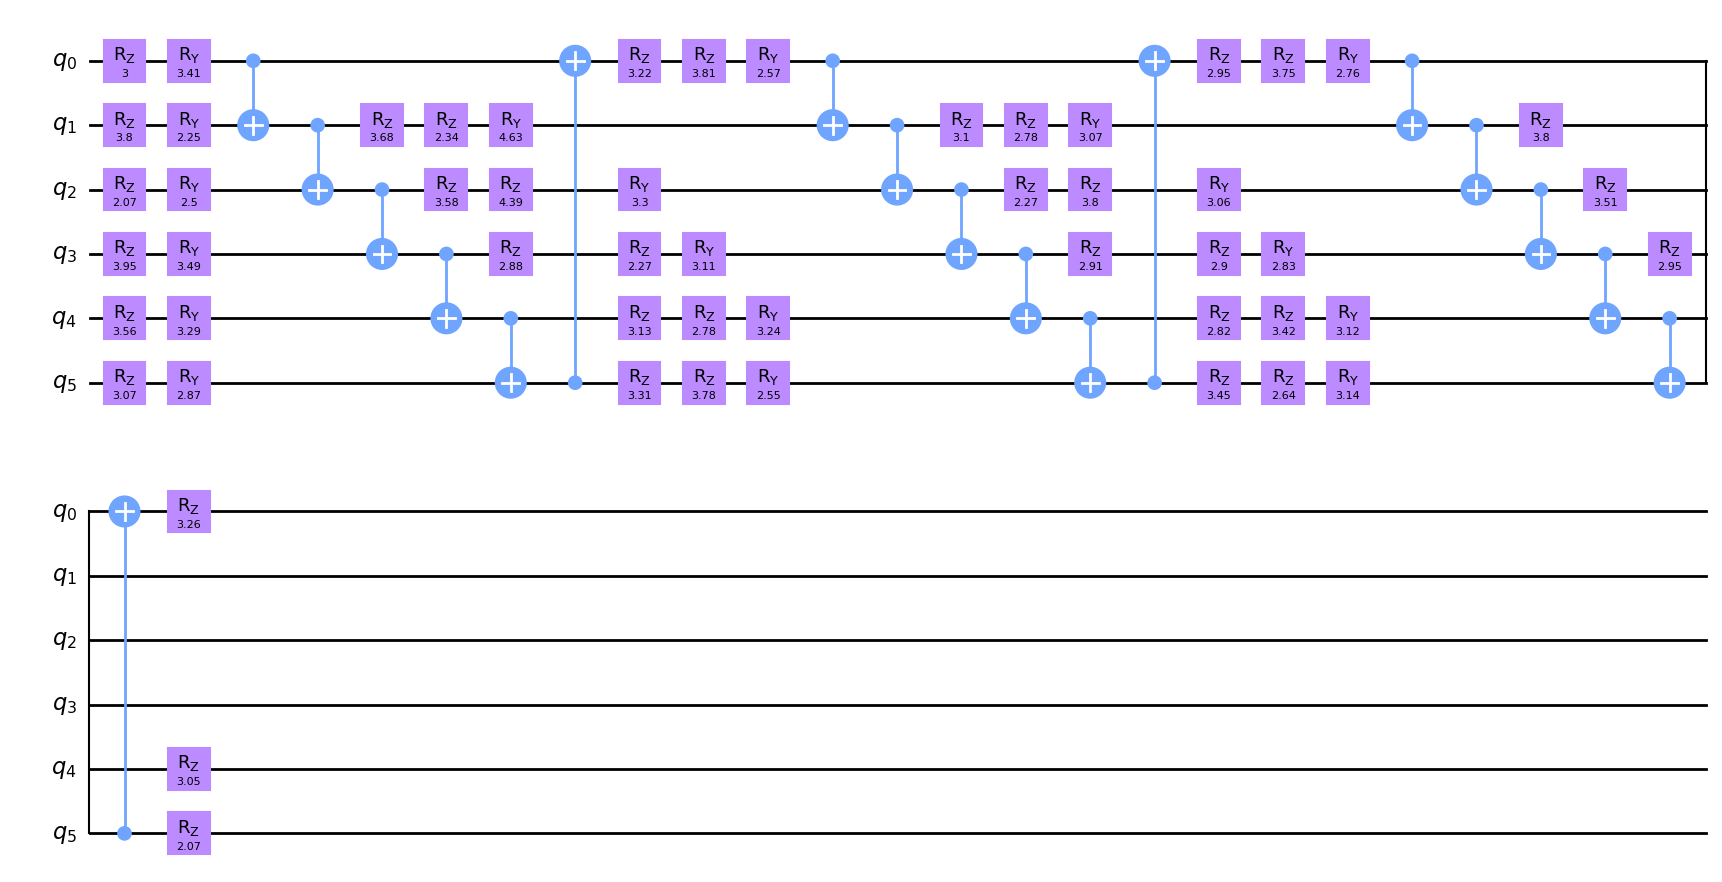

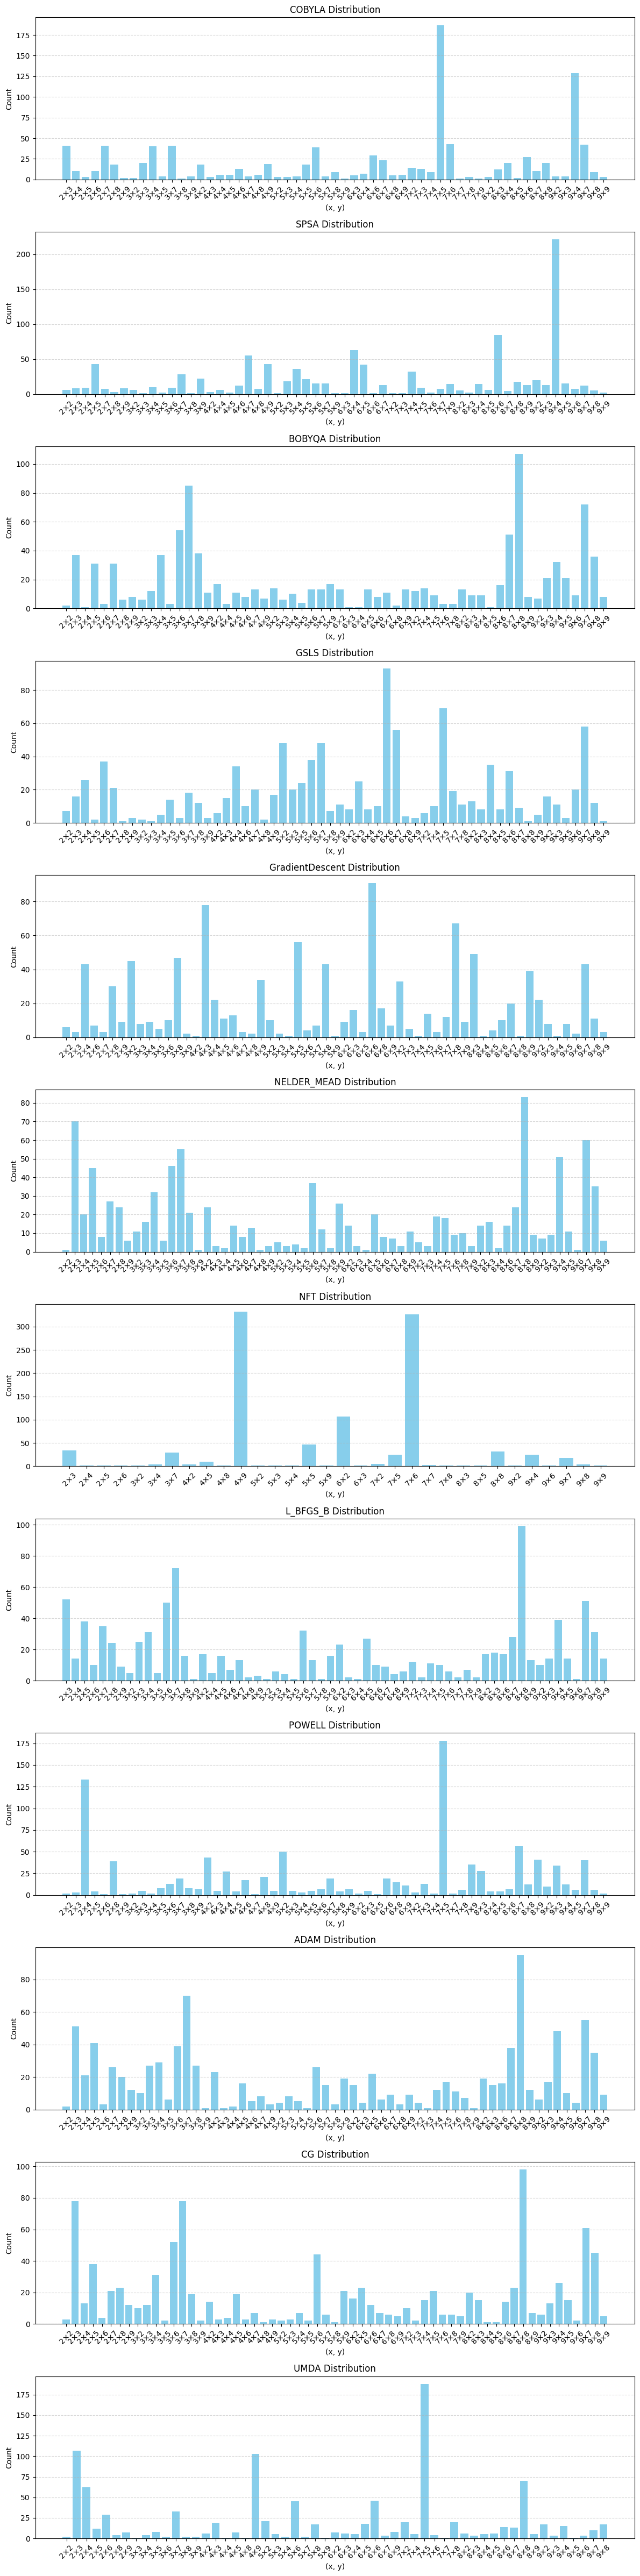


Top 5 most frequent (x, y) pairs for COBYLA:
x=7, y=5, count=187
x=9, y=4, count=129
x=7, y=6, count=43
x=9, y=7, count=42
x=2, y=3, count=41

Top 5 most frequent (x, y) pairs for SPSA:
x=9, y=4, count=221
x=8, y=6, count=84
x=6, y=4, count=63
x=4, y=7, count=55
x=4, y=9, count=43

Top 5 most frequent (x, y) pairs for BOBYQA:
x=8, y=8, count=107
x=3, y=7, count=85
x=9, y=7, count=72
x=3, y=6, count=54
x=8, y=7, count=51

Top 5 most frequent (x, y) pairs for GSLS:
x=6, y=6, count=93
x=7, y=5, count=69
x=9, y=7, count=58
x=6, y=7, count=56
x=5, y=2, count=48

Top 5 most frequent (x, y) pairs for GradientDescent:
x=6, y=6, count=91
x=4, y=3, count=78
x=7, y=8, count=67
x=5, y=5, count=56
x=8, y=3, count=49

Top 5 most frequent (x, y) pairs for NELDER_MEAD:
x=8, y=8, count=83
x=2, y=3, count=70
x=9, y=7, count=60
x=3, y=7, count=55
x=9, y=4, count=51

Top 5 most frequent (x, y) pairs for NFT:
x=4, y=9, count=332
x=7, y=6, count=326
x=6, y=2, count=107
x=5, y=5, count=47
x=2, y=3, count=34

In [15]:
# ------------------------------
# 5. Optimizer Evaluation (SciPy)
# ------------------------------
"""
shared_init_theta = np.random.uniform(0, 2 * np.pi, len(params))  # Shared初始參數隨機初始化(隨機角度)

def run_optimizer(method_name, maxiter=200):  # 執行一次 optimizer 並回傳最佳成本值
    init_theta = shared_init_theta.copy()
    start = time.time()
    res = minimize(expectation, init_theta, method=method_name, options={'maxiter': maxiter})
    end = time.time()

    print(f"\nOptimizer: {method_name}")
    print("Iterations:", getattr(res, "nit", "N/A"))
    print("Evaluation function times:", getattr(res, "nfev", "N/A"))
    # print("Success:", getattr(res, "success", "N/A"))
    print("Message:", getattr(res, "message", "N/A"))
    print("Elapsed time: {:.2f} seconds".format(end - start))
    print("Best cost:", res.fun)

    bound_circuit = ansatz.assign_parameters({params[i]: res.x[i] for i in range(len(params))})  # 顯示最佳參數後的電路圖
    print("\nBest parameterized circuit:")
    display(bound_circuit.draw("mpl"))
    
    return res.fun  # 回傳最佳成本值

# ------------------------------
# 5. Optimizer Evaluation (Qiskit)
# ------------------------------
def run_qiskit_optimizer(optimizer, label="Qiskit", maxiter=200):
    init_theta = shared_init_theta.copy()
    start = time.time()

    # 若 Optimizer 支援 set_options，例如 BOBYQA，可設定 maxiter
    if hasattr(optimizer, "set_options"):
        optimizer.set_options(maxiter=maxiter)
    try:
        result = optimizer.minimize(fun=expectation, x0=init_theta, bounds=[(0, 2 * np.pi)] * len(init_theta))
    except TypeError:
        result = optimizer.minimize(fun=expectation, x0=init_theta)

    end = time.time()

    print(f"\nOptimizer: {label}")
    print("Iterations:", getattr(result, "nit", "N/A"))
    print("Function evaluations:", getattr(result, "nfev", "N/A"))
    print("Message:", getattr(result, "message", "N/A"))
    print("Elapsed time: {:.2f} seconds".format(end - start))
    print("Best cost:", result.fun)

    bound_circuit = ansatz.assign_parameters({params[i]: result.x[i] for i in range(len(params))})
    print("\nBest parameterized circuit:")
    display(bound_circuit.draw("mpl"))

    return result.fun
"""
# ------------------------------
# 5. Optimizer Evaluation (Qiskit-only)
# ------------------------------
shared_init_theta = np.random.uniform(0, 2 * np.pi, len(params))

def run_qiskit_optimizer(optimizer, label="Qiskit", maxiter=200):
    init_theta = shared_init_theta.copy()
    start = time.time()

    if hasattr(optimizer, "set_options"):
        optimizer.set_options(maxiter=maxiter)

    try:
        result = optimizer.minimize(fun=expectation, x0=init_theta, bounds=[(0, 2 * np.pi)] * len(init_theta))
    except TypeError:
        result = optimizer.minimize(fun=expectation, x0=init_theta)

    end = time.time()

    print(f"\nOptimizer: {label}")
    print("Iterations:", getattr(result, "nit", "N/A"))
    print("Function evaluations:", getattr(result, "nfev", "N/A"))
    # print("Success:", getattr(result, "success", "N/A"))
    # print("Message:", getattr(result, "message", "N/A"))
    print("Elapsed time: {:.2f} seconds".format(end - start))
    print("Best cost:", result.fun)

    bound_circuit = ansatz.assign_parameters({params[i]: result.x[i] for i in range(len(params))})
    print("\nBest parameterized circuit:")
    display(bound_circuit.draw("mpl"))

    return result.fun

# ------------------------------
# 6. Main Execution
# ------------------------------
# optimizers = ["Nelder-Mead", "COBYLA", "Powell", (SPSA(maxiter=100), "SPSA"), (BOBYQA(), "BOBYQA")]
optimizers = [
    (COBYLA(maxiter=500), "COBYLA"),
    (SPSA(maxiter=500), "SPSA"),
    (BOBYQA(maxiter=500), "BOBYQA"),
    (GSLS(maxiter=500), "GSLS"),
    (GradientDescent(maxiter=500), "GradientDescent"),
    (NELDER_MEAD(maxiter=500), "NELDER_MEAD"),
    (NFT(maxiter=500), "NFT"),
    (L_BFGS_B(maxiter=500), "L_BFGS_B"),
    (POWELL(maxiter=500), "POWELL"),
    (ADAM(maxiter=500), "ADAM"),
    (CG(maxiter=500), "CG"),
    (UMDA(maxiter=500), "UMDA")
]

results = {}  # 每個 optimizer 的 cost 結果
xy_distributions = {}  # 每個 optimizer 的 (x,y) 出現次數分布

"""
for opt in optimizers:  # 對每個 optimizer 執行一次最佳化流程
    final_xy_counter.clear()
    if isinstance(opt, tuple):  # Qiskit optimizer (optimizer, name)
        optimizer_obj, label = opt
        cost = run_qiskit_optimizer(optimizer_obj, label=label)
    else:  # SciPy optimizer
        label = opt
        cost = run_optimizer(label)
    results[label] = cost
    xy_distributions[label] = dict(final_xy_counter)
"""

for optimizer, label in optimizers:
    final_xy_counter.clear()
    cost = run_qiskit_optimizer(optimizer, label=label)
    results[label] = cost
    xy_distributions[label] = dict(final_xy_counter)


# Plot results distributions
fig, axs = plt.subplots(len(optimizers), 1, figsize=(12, 4 * len(optimizers)))  # 每個 optimizer 的結果各別畫出直方圖
axs = axs.flatten()

"""
for i, opt in enumerate(optimizers):
    ax = axs[i]
    label = opt if isinstance(opt, str) else opt[1]
    counter = dict(sorted(xy_distributions[label].items()))
    labels = [f"{x}×{y}" for (x, y) in counter]
    values = list(counter.values())
    ax.bar(labels, values, color='skyblue')
    ax.set_title(f"{opt} Distribution")
    ax.set_ylabel("Count")
    ax.set_xlabel("(x, y)")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
"""

for i, (_, label) in enumerate(optimizers):
    ax = axs[i]
    counter = dict(sorted(xy_distributions[label].items()))
    labels = [f"{x}×{y}" for (x, y) in counter]
    values = list(counter.values())
    ax.bar(labels, values, color='skyblue')
    ax.set_title(f"{label} Distribution")
    ax.set_ylabel("Count")
    ax.set_xlabel("(x, y)")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


# Show top 5 results for each optimizer
from operator import itemgetter

"""
for opt in results:
    print(f"\nTop 5 most frequent (x, y) pairs for {opt}:")
    sorted_results = sorted(xy_distributions[opt].items(), key=itemgetter(1), reverse=True)
    for (x, y), c in sorted_results[:5]:
        print(f"x={x}, y={y}, count={c}")
"""

for label in results:
    print(f"\nTop 5 most frequent (x, y) pairs for {label}:")
    sorted_results = sorted(xy_distributions[label].items(), key=itemgetter(1), reverse=True)
    for (x, y), c in sorted_results[:5]:
        print(f"x={x}, y={y}, count={c}")

In [16]:
import qiskit, qiskit_aer, qiskit_algorithms, matplotlib
print("Versions:")
print("Qiskit:", qiskit.__version__)
print("Qiskit_Aer:", qiskit_aer.__version__)
print("Qiskit_Algorithms.optimizers:", qiskit_algorithms.__version__)
print("Numpy:", np.__version__)
print("Matplotlib.pyplot:", matplotlib.__version__)


Versions:
Qiskit: 0.24.1
Qiskit_Aer: 0.12.0
Qiskit_Algorithms.optimizers: 0.2.1
Numpy: 1.23.5
Matplotlib.pyplot: 3.9.4
